### Decoding from fMRI data

In this notebook we will use the Haxby et al. data that were prepared in the Data Setup notebook to perform classification.



In [1]:
import os
import h5py
import numpy as np
import nibabel as nib
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
import warnings
from utils import get_data_frame, get_subject_runs, get_difumo_mask, get_subject_common_brain_mask
import tqdm
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from nilearn.image import resample_img
from nilearn.maskers import NiftiMasker
import nilearn.plotting
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor
from bids import BIDSLayout
from collections import defaultdict

base_dir = "/Users/poldrack/data_unsynced/ds000105"
glm_dir = os.path.join(base_dir, 'derivatives', 'glm')

device = 'cuda' if torch.cuda.is_available() else \
    "mps" if torch.backends.mps.is_available() else "cpu"   
print(f"Using device {device}")


Using device mps


### Load the data



In [ ]:
# h5 version

glm_dir = os.path.join(base_dir, 'derivatives', 'glm')
overwrite = False
layout = BIDSLayout(base_dir)
print(layout)
subjects = [int(i) for i in layout.get_subjects()]

all_data = {}

with h5py.File(os.path.join(output_dir, 'bold_data.h5'), 'w') as hf:

for subject in subjects:
    outfile = os.path.join(glm_dir, f"sub-{subject}_bolddata.parquet")
    if os.path.exists(outfile) and not overwrite:
        print(f"Loading existing data for subject {subject}")
        all_data[subject] = pl.read_parquet(outfile)
        continue
    bold_data = None
    subject = int(subject)
    print(f"Processing subject {subject}")
    runs = get_subject_runs(subject, layout.root)
    mask_img = get_subject_common_brain_mask(subject, layout.root)
    masker = NiftiMasker(mask_img=mask_img)
    for run in runs:
        print(f"Processing subject {subject} run {run}")
        bold_file = os.path.join(glm_dir, f"zmaps/sub-{subject}_run-{run}_zmaps.nii.gz")
        bold_img = nib.load(bold_file)
        run_data = masker.fit_transform(bold_img)
        run_df = pl.DataFrame(run_data)
        run_df.columns = [f"voxel_{i}" for i in range(run_df.shape[1])]
        run_df = run_df.with_columns(pl.Series("condition", np.arange(run_df.shape[0])))
        run_df = run_df.with_columns(pl.lit(run).alias('run'))
        run_df = run_df.with_columns(pl.lit(subject).alias('subject'))
        if bold_data is None:
            bold_data = run_df
        else:
            bold_data = pl.concat([bold_data, run_df])
    outfile = os.path.join(glm_dir, f"sub-{subject}_bolddata.parquet")
    bold_data.write_parquet(outfile)
    all_data[subject] = bold_data

### Run decoding model

Use a leave-one-run-out crossvalidation scheme

In [86]:

# leave one run out cross validation

def run_cv_subject(data, metadata_df, nfeatures=None, shuffle=False, 
           varthresh=None, clf=None, suppress_warnings=False):
    """
    Perform cross-validation for decoding analysis.

    Parameters:
    - data_df (pandas.DataFrame): The input data frame containing the features and labels.
    - nfeatures (int): The number of features to select using ANOVA. Default is 1000, or None to disable.
    - shuffle_y (bool): Whether to shuffle the labels. Default is False
    - varthresh (float): The variance threshold for feature selection. Default is 0, or None to disable.
    - clf (sklearn classifier): The classifier to use. Default is None, which uses a Support Vector Machine

    Returns:
    - accs (list): A list of accuracy scores for each cross-validation fold.
    """
    if clf is None:
        clf = SGDClassifier() # by default is like SVM with l2 regularization

    # Suppress warnings from scikit-learn
    if suppress_warnings:
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Leave one run out cross-validation
    logo = LeaveOneGroupOut()
    assert data.shape[0] == metadata_df.shape[0]
    logo.get_n_splits(data, groups=metadata_df['run'].values)

    if shuffle:
        metadata_df.conditions = np.random.permutation(metadata_df.conditions)

    # perform variance thresholding with default of zero
    if varthresh is not None:
        vt = VarianceThreshold(threshold=varthresh)
        vox_df = vt.fit_transform(data)

    accs = []
    coefs = None
    for train_index, test_index in logo.split(data, groups=metadata_df.run):
        train_X = data[train_index]
        assert train_X.shape[0] == len(train_index)
        assert train_X.shape[1] == data.shape[1]
        test_X = data[test_index]
        train_y = metadata_df.conditions[train_index]
        test_y = metadata_df.conditions[test_index]
        
        if nfeatures is not None:
            # Feature selection based on training data only
            selector = SelectKBest(score_func=f_classif, k=nfeatures)
            train_data_selected = selector.fit_transform(train_X, train_y)
            test_data_selected = selector.transform(test_X)
        else:
            train_data_selected = train_X
            test_data_selected = test_X

        clf.fit(train_data_selected, train_y)
        if coefs is None:
            coefs = clf.coef_ 
        else:
            coefs += clf.coef_ 
        acc = accuracy_score(test_y, clf.predict(test_data_selected))
        accs.append(acc)
    mean_coefs = coefs / len(accs)
    return accs, mean_coefs


def get_runs_from_hf(hf, subject):
    runs = [int(i.split('-')[-1]) for i in hf[subject].keys()]
    runs.sort()
    return runs

def get_sub_data_from_hf(hf, subnum, data_key='braindata'):
    subject = f'sub-{subnum}'
    runs = get_runs_from_hf(hf, subject)
    data = None
    run_num = []
    condition = []
    for run_key in runs:
        run = f'run-{run_key}'
        try:
            run_data = hf[subject][run][data_key][:]
        except KeyError:
            print(f'No data found for {subject} {run}')
            continue
        if data is None:
            data = run_data
        else:
            data = np.concatenate((data, run_data))
        run_num.extend([int(run_key)] * run_data.shape[0])
        condition.extend(hf[subject][run]['conditions'][:])
    condition = [i.decode('utf-8') for i in condition]
    metadata_df = pd.DataFrame({'run': run_num, 'conditions': condition})
    assert data.shape[0] == metadata_df.shape[0]
    return data, metadata_df
        
def run_cv(hf, clf=None, shuffle=False, nfeatures=None, varthresh=None,
           data_key='braindata'):
    if clf is None:
        clf = SGDClassifier()
    print(f'Running cross-validation with {clf}')
    if nfeatures is not None:
        print(f'Selecting best {nfeatures} features: ')
    if varthresh is not None:
        print(f'Performing variance thresholding with threshold {varthresh}')
    if shuffle:
        print('Including shuffled data')
    accs = {}
    coefs = {}

    # would usually run this many more times for shuffled data
    nshuffles = 1
    shuffle_vals = [False, True] if shuffle else [False]

    for subject in range(1, 7):
        subdata, metadata_df = get_sub_data_from_hf(hf, subject, data_key=data_key)
        print(f'Subject {subject}')
        print(f'data shape: {subdata.shape}')
        accs[subject] = {}
        for shuffle_y in shuffle_vals:
            shuffled_string = 'shuffled' if shuffle_y else 'orig'
            nruns = nshuffles if shuffle_y else 1
            accs[subject][shuffled_string] = 0
            for i in range(nshuffles):
                acc_, coef_ = run_cv_subject(subdata, metadata_df, nfeatures=nfeatures, 
                                    shuffle=shuffle_y, varthresh=varthresh, 
                                    clf=clf)
                if shuffle_y is False:
                    coefs[subject] = coef_
                accs[subject][shuffled_string] += np.mean(acc_)
            accs[subject][shuffled_string] /= nshuffles
            print(f'Mean accuracy ({shuffled_string}): {np.mean(accs[subject][shuffled_string]):.03}')

        print('')
    return accs, coefs


# run crossvalidation across subjects with default settings
# need to run without thresholding or feature selection to get the full set of coefs
with h5py.File(os.path.join(glm_dir, 'haxby_data.h5'), 'r') as hf:
    conditions = hf['sub-1']['run-1']['conditions'][:]
    accs, coefs = run_cv(hf, nfeatures=None, shuffle=False, data_key='vtmaskdata')

Running cross-validation with SGDClassifier()
Subject 1
data shape: (96, 20577)
Mean accuracy (orig): 0.833

Subject 2
data shape: (96, 20577)
Mean accuracy (orig): 0.75

Subject 3
data shape: (96, 20577)
Mean accuracy (orig): 0.823

Subject 4
data shape: (96, 20577)
Mean accuracy (orig): 0.802

Subject 5
data shape: (88, 20577)
Mean accuracy (orig): 0.898

Subject 6
data shape: (96, 20577)
Mean accuracy (orig): 0.688



#### Visualizing the coefficients


(8, 20577)


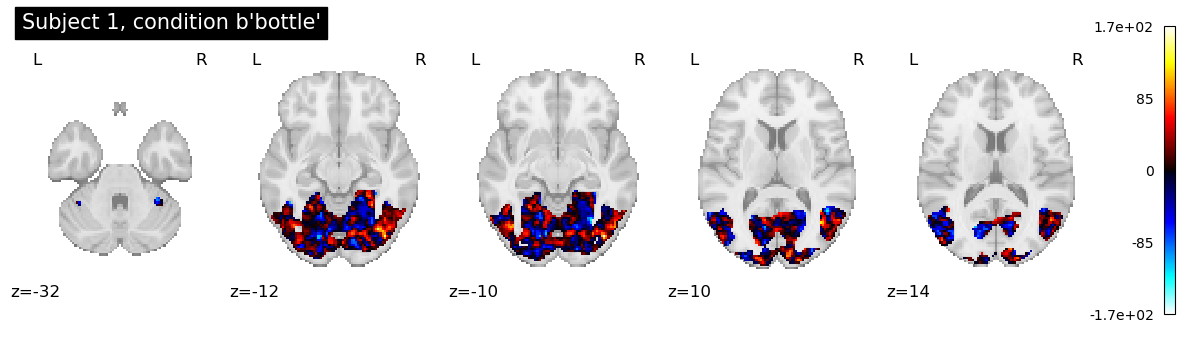

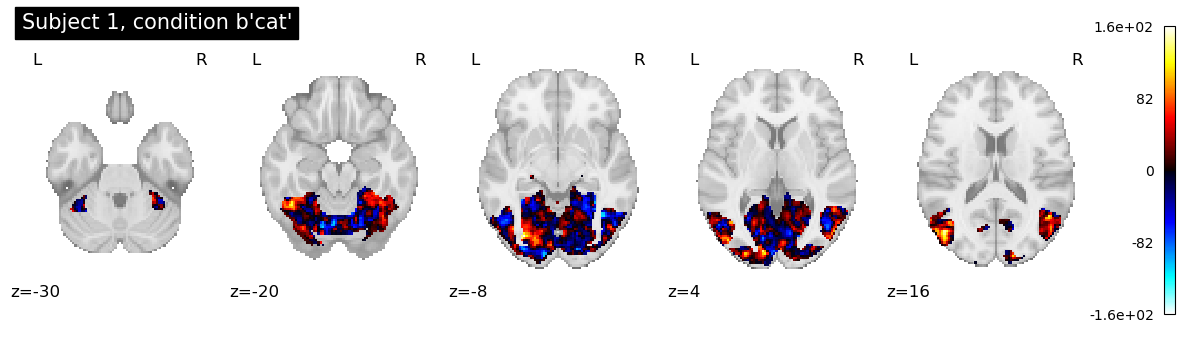

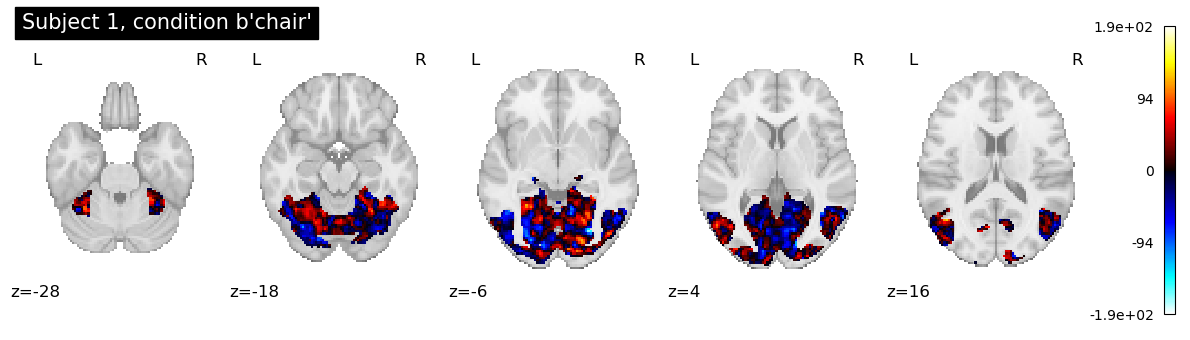

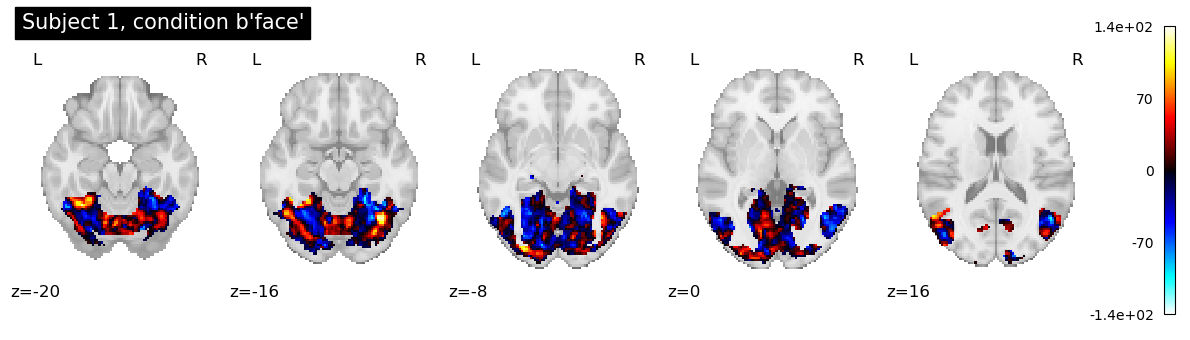

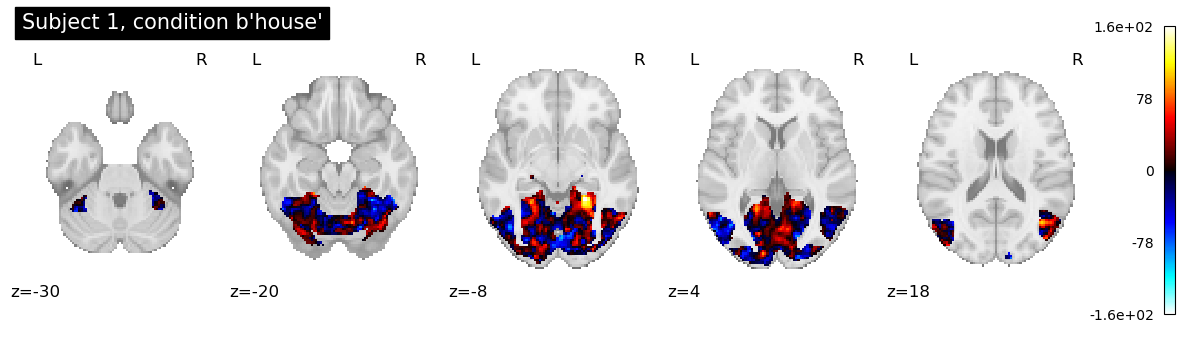

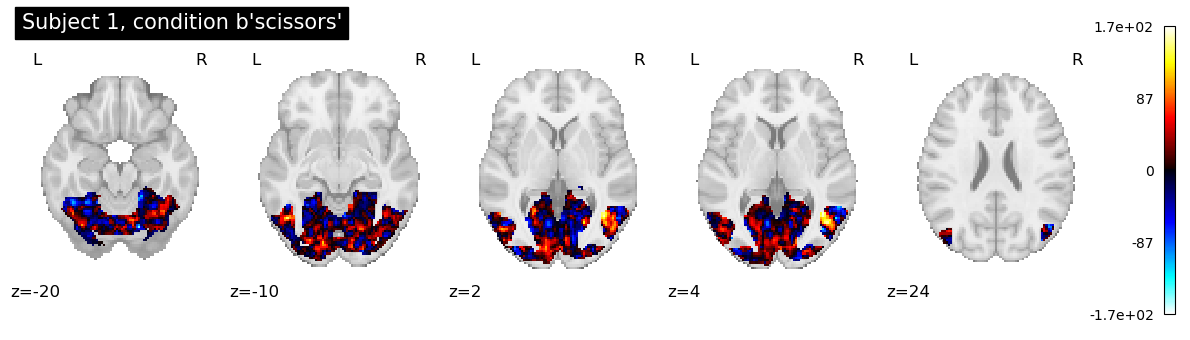

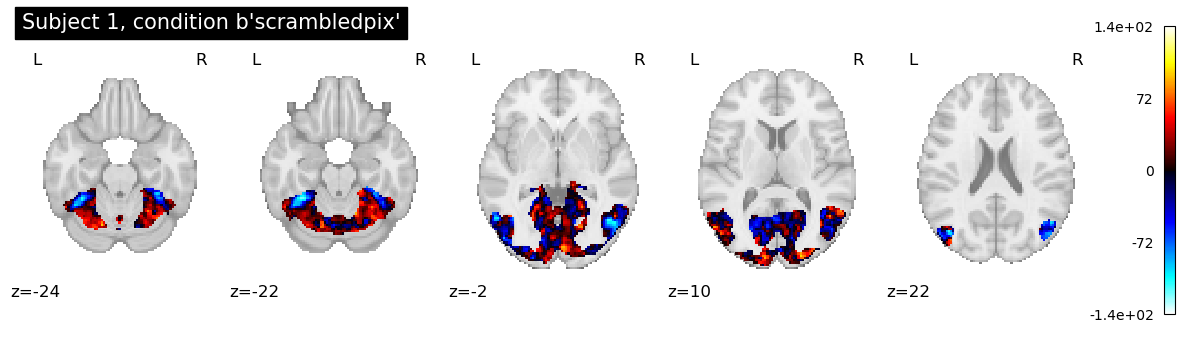

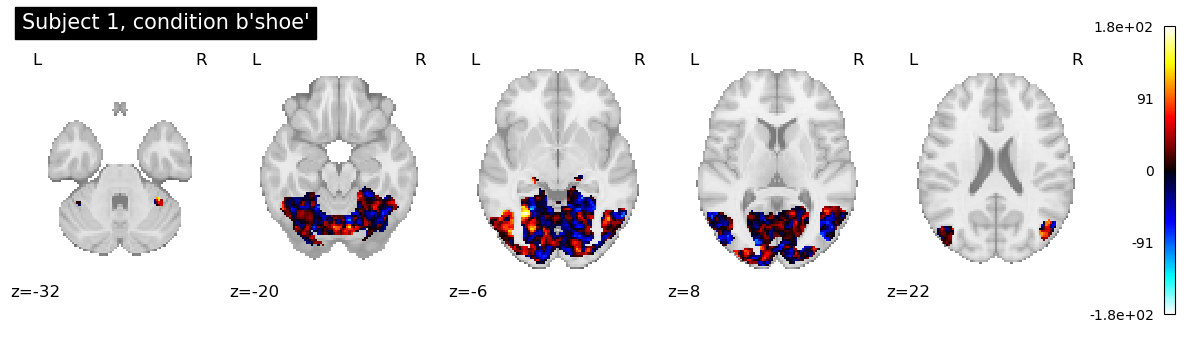

In [88]:

def visualize_coefs(coefs, conditions):
    mask_img = get_difumo_mask()
    masker = NiftiMasker(mask_img)
    masker.fit()

    # plot the mean coefficients
    for subject in range(1, 2):
        print(coefs[subject].shape)
        coef_img = masker.inverse_transform(coefs[subject])
        for c in range(coefs[subject].shape[0]):
            nilearn.plotting.plot_stat_map(coef_img.slicer[..., c], display_mode='z', cut_coords=5,
                                           title=f'Subject {subject}, condition {conditions[c]}')

visualize_coefs(coefs, conditions)


### Effect of different regularization schemes

In the previous model, we used a support vector machine with an L2 penalty, which penalizes the sum of squared weights. We can also look at the effect using a different penalty, namely an L1 penalty, which penalizes based on the sum of absolute weights, and leads in general to sparser solutions (more zero weights).

We can set the `LinearSVC` classifier to use L1 penalization.

Running cross-validation with SGDClassifier(alpha=0.01, penalty='l1')
Subject 1
data shape: (96, 20577)
Mean accuracy (orig): 0.823

Subject 2
data shape: (96, 20577)
Mean accuracy (orig): 0.719

Subject 3
data shape: (96, 20577)
Mean accuracy (orig): 0.802

Subject 4
data shape: (96, 20577)
Mean accuracy (orig): 0.719

Subject 5
data shape: (88, 20577)
Mean accuracy (orig): 0.898

Subject 6
data shape: (96, 20577)
Mean accuracy (orig): 0.698

(8, 20577)


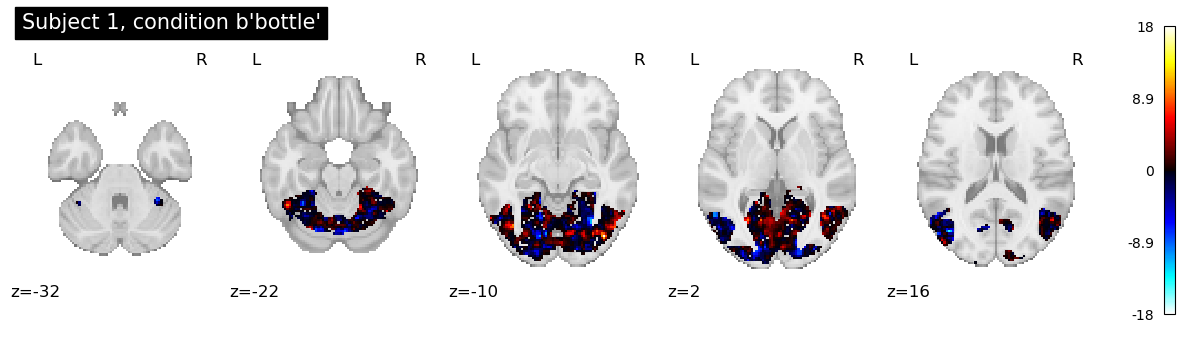

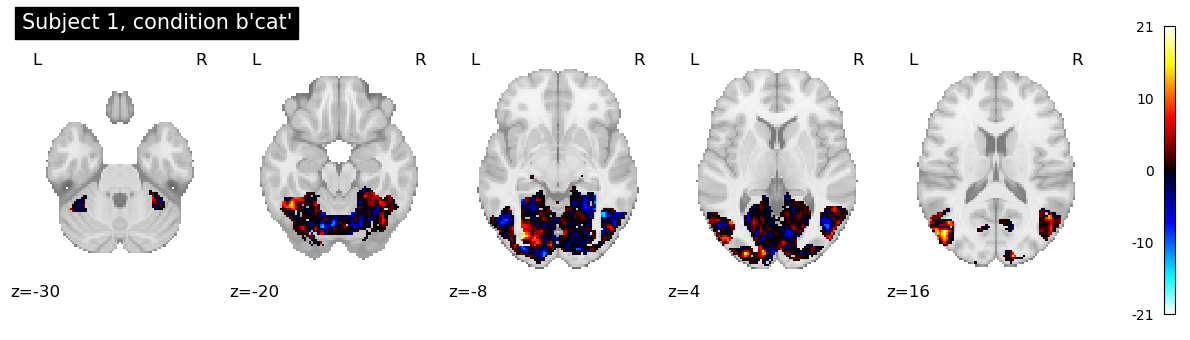

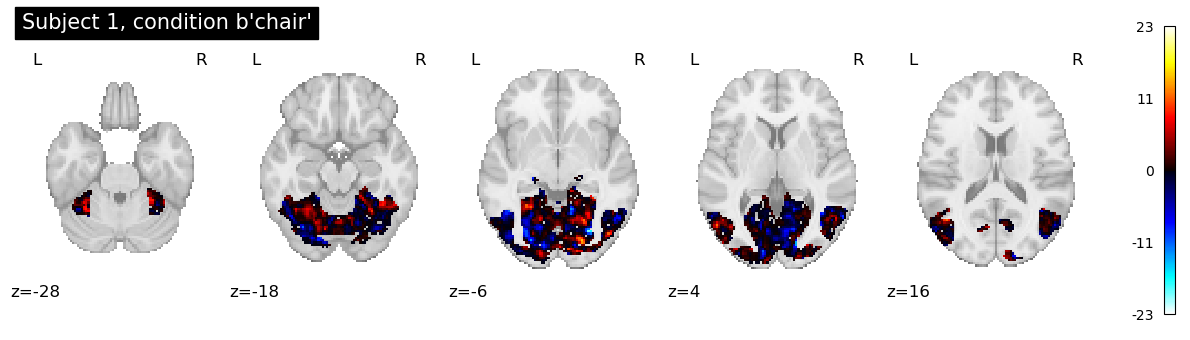

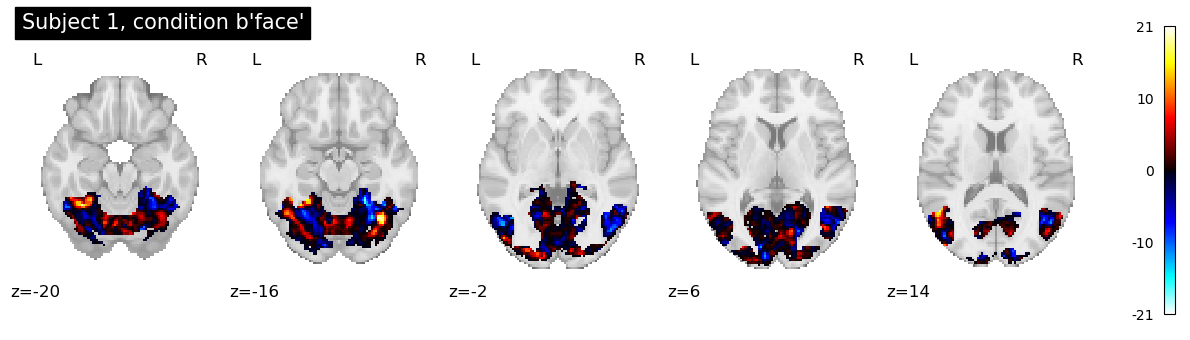

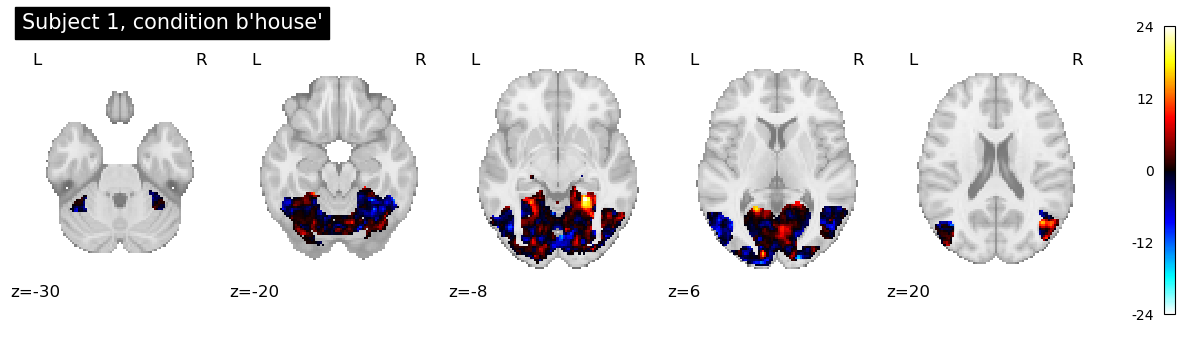

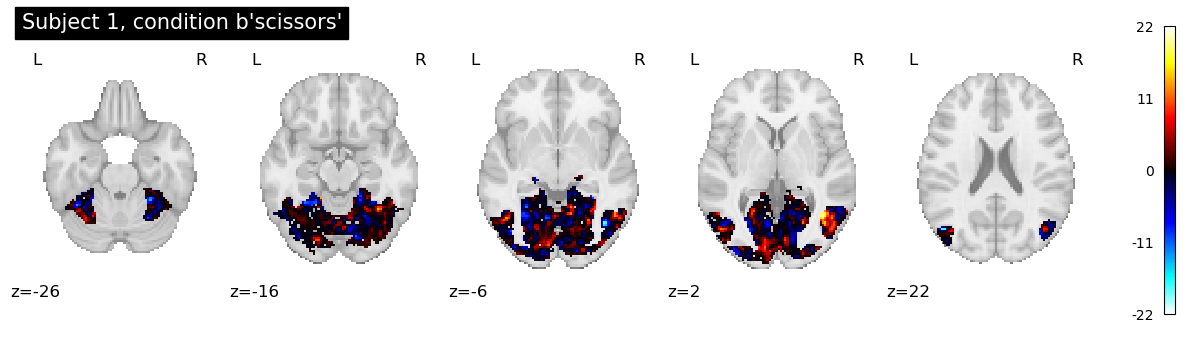

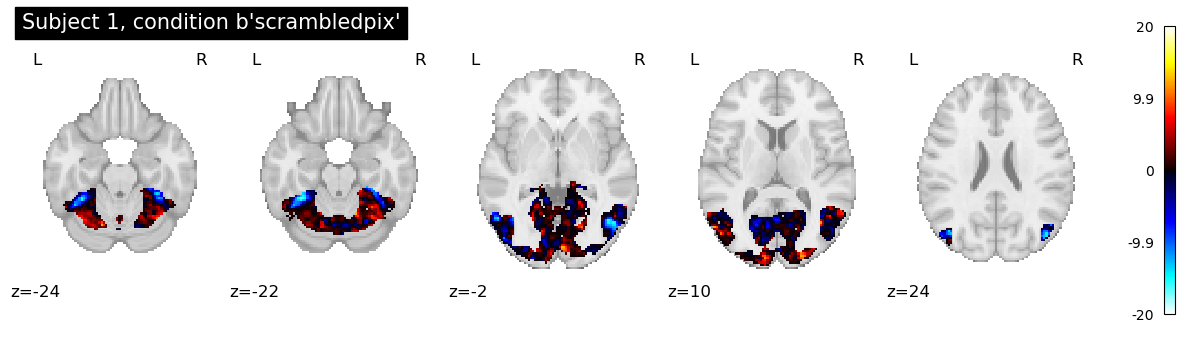

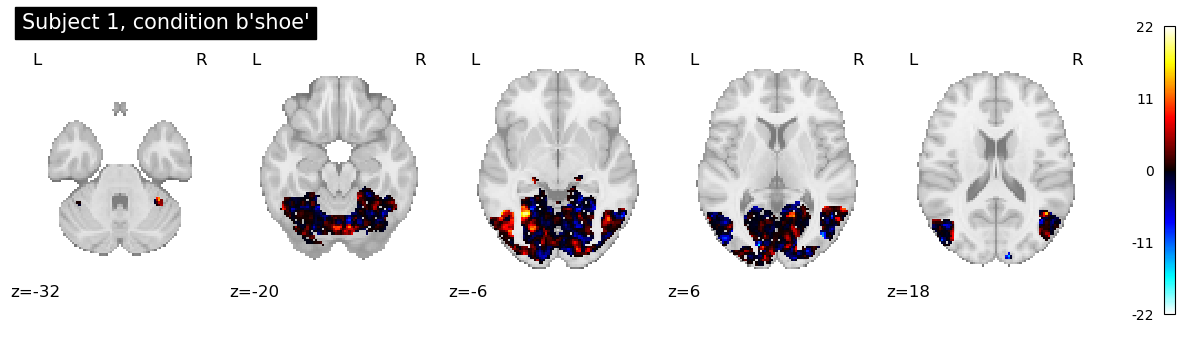

In [93]:
with h5py.File(os.path.join(glm_dir, 'haxby_data.h5'), 'r') as hf:
    conditions = hf['sub-1']['run-1']['conditions'][:]
    accs_L1, coefs_L1 = run_cv(hf, nfeatures=None, shuffle=False, 
                               clf=SGDClassifier(penalty='l1', alpha=0.01), 
                               data_key='vtmaskdata')

visualize_coefs(coefs_L1, conditions)


### Single-layer perceptron

Now we will use a simple neural network model: a one-layer perceptron, which has a single layer of modifiable weights.  The input units are the voxels within the mask, and the output units represent the eight tasks.  We will train the network by giving it the voxel data along with a "one hot" encoding of the task, and the modify the weights using gradient descent.  

In [94]:

def get_tensor_data(subject, glm_dir, data_key='vtmaskdata', device='mps'):
    with h5py.File(os.path.join(glm_dir, 'haxby_data.h5'), 'r') as hf:
        data, metadata_df = get_sub_data_from_hf(hf, subject, data_key=data_key)

    fmridata_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    enc = OneHotEncoder(handle_unknown='ignore')
    output_tensor = torch.tensor(enc.fit_transform(metadata_df.conditions.to_numpy().reshape(-1, 1)).toarray(), 
                                 dtype=torch.float).to(device)
    return fmridata_tensor, output_tensor, metadata_df





In [95]:
# based on https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_inputs, n_outputs),
            nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [115]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return(loss)


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

def get_dataloaders(test_run, metadata_df, fmridata_tensor, output_tensor, batch_size=10):
    HaxbyDataset_train = TensorDataset(fmridata_tensor[metadata_df.run!=test_run], output_tensor[metadata_df.run!=test_run])
    HaxbyLoader_train = DataLoader(HaxbyDataset_train, batch_size=batch_size, shuffle=True)

    HaxbyDataset_test = TensorDataset(fmridata_tensor[metadata_df.run==test_run], output_tensor[metadata_df.run==test_run])
    HaxbyLoader_test = DataLoader(HaxbyDataset_test, batch_size=batch_size, shuffle=True)
    return HaxbyLoader_train, HaxbyLoader_test




In [117]:
def train_test_perceptron(subject, glm_dir, device='mps', epochs=1000, learning_rate=1e-3):
    fmridata_tensor, output_tensor, metadata_df = get_tensor_data(subject, glm_dir)
    model = NeuralNetwork(
        fmridata_tensor.shape[1],
        output_tensor.shape[1]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    runs = get_subject_runs(subject, base_dir)

    loss_fn = nn.CrossEntropyLoss()
    HaxbyLoader_train, HaxbyLoader_test = get_dataloaders(1, metadata_df, fmridata_tensor, output_tensor)

    train_loss = []
    test_loss = []
    test_correct = []
    writer = SummaryWriter()

    for t in range(epochs):
        correct, trainloss, testloss = [], [], []
        for test_run in runs:
            HaxbyLoader_train, HaxbyLoader_test = get_dataloaders(test_run, metadata_df, fmridata_tensor, output_tensor)
            trainloss.append(train_loop(HaxbyLoader_train, model, loss_fn, optimizer).cpu().detach().numpy())
            writer.add_scalar("Loss/train", trainloss[-1], t)
            testresult = test_loop(HaxbyLoader_test, model, loss_fn)
            writer.add_scalar("Loss/test", testresult[0], t)
            writer.add_scalar("Accuracy/test", testresult[1], t)
            testloss.append(testresult[0])
            correct.append(testresult[1])
        train_loss.append(np.mean(trainloss))
        test_loss.append(np.mean(testloss))
        test_correct.append(np.mean(correct))

    print(f'train loss: {train_loss[-1]:.03}')
    print(f'test loss: {test_loss[-1]:.03}')
    print(f'test correct: {test_correct[-1]:.03}')
    print('')
    writer.flush()
    writer.close()
    return model

models = {}
for subject in range(1, 7):
    print(f'Subject {subject}')
    models[subject] = train_test_perceptron(subject, glm_dir, epochs = 100, learning_rate=1e-4)

Subject 1
train loss: 0.00436
test loss: 0.0044
test correct: 1.0

Subject 2
train loss: 0.0697
test loss: 0.0695
test correct: 0.979

Subject 3
train loss: 0.0466
test loss: 0.0468
test correct: 1.0

Subject 4
train loss: 0.0253
test loss: 0.0254
test correct: 0.99

Subject 5
train loss: 0.0228
test loss: 0.0277
test correct: 0.989

Subject 6
train loss: 0.22
test loss: 0.134
test correct: 0.969



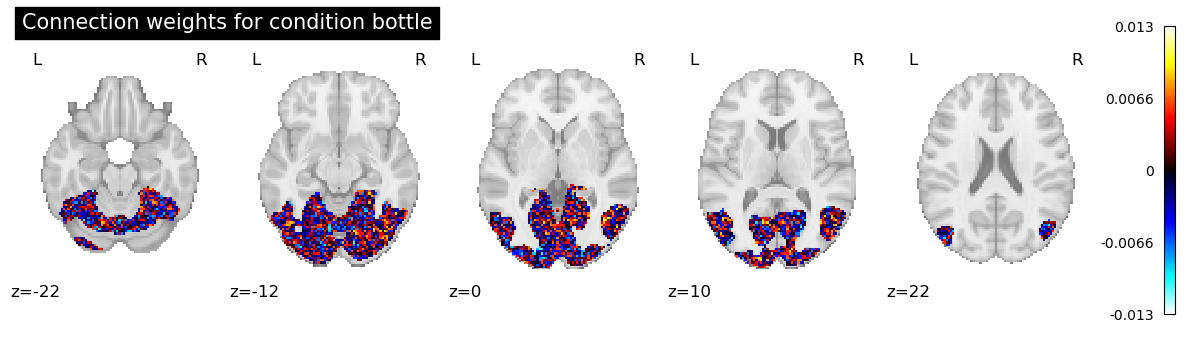

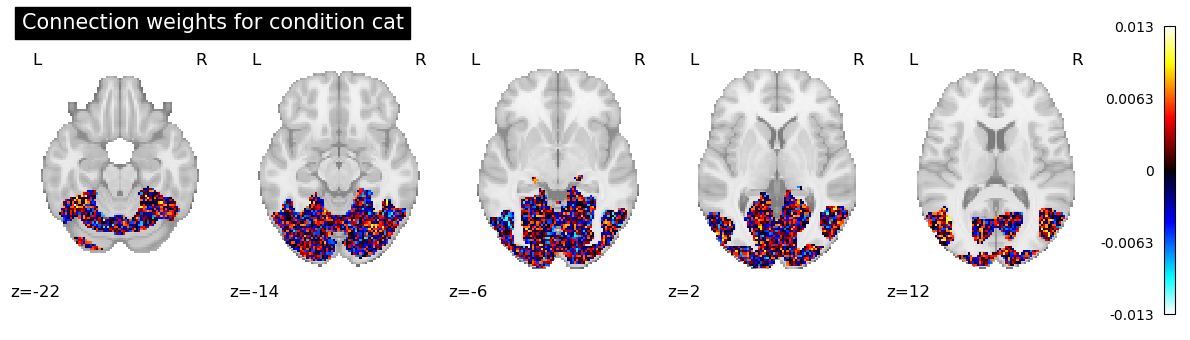

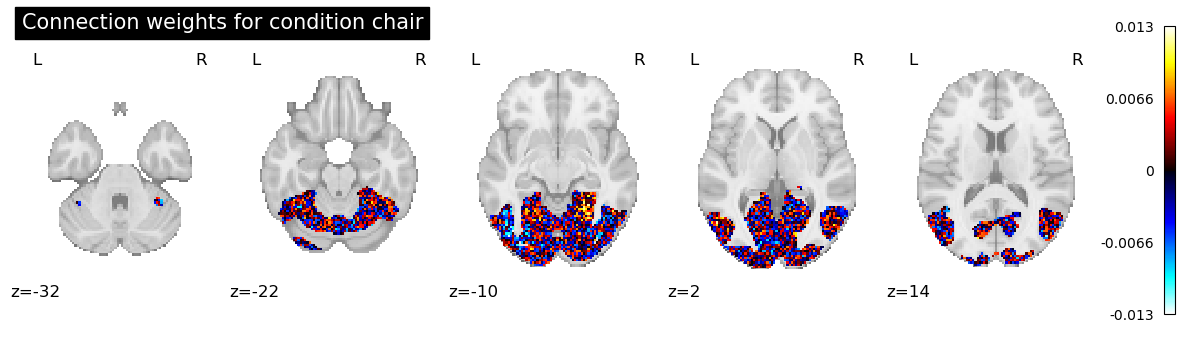

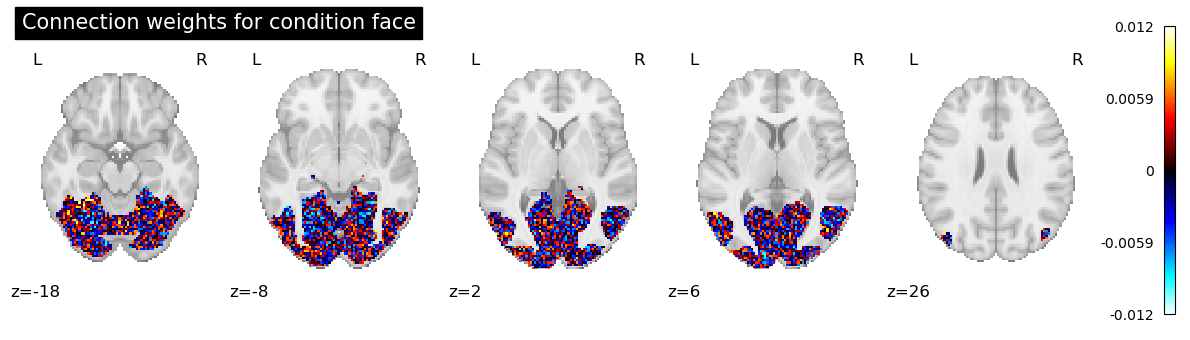

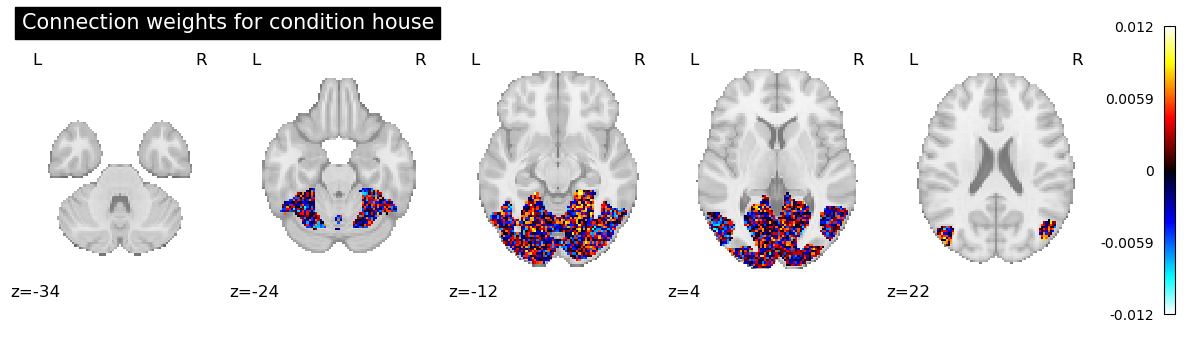

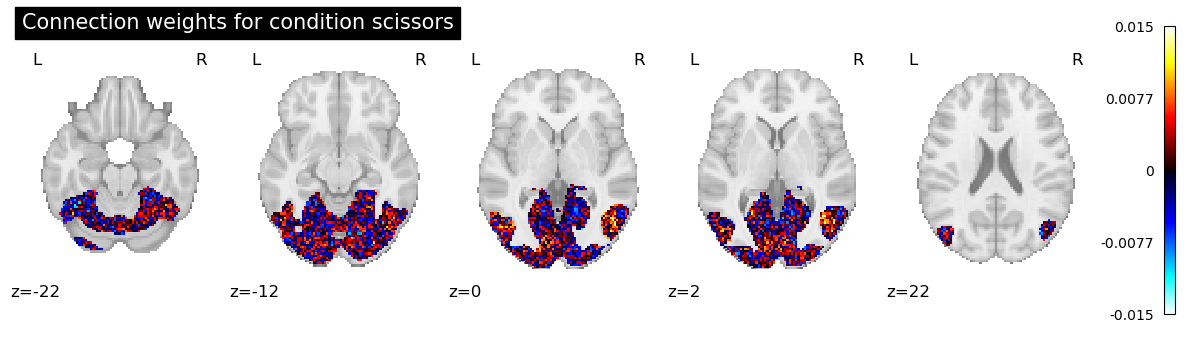

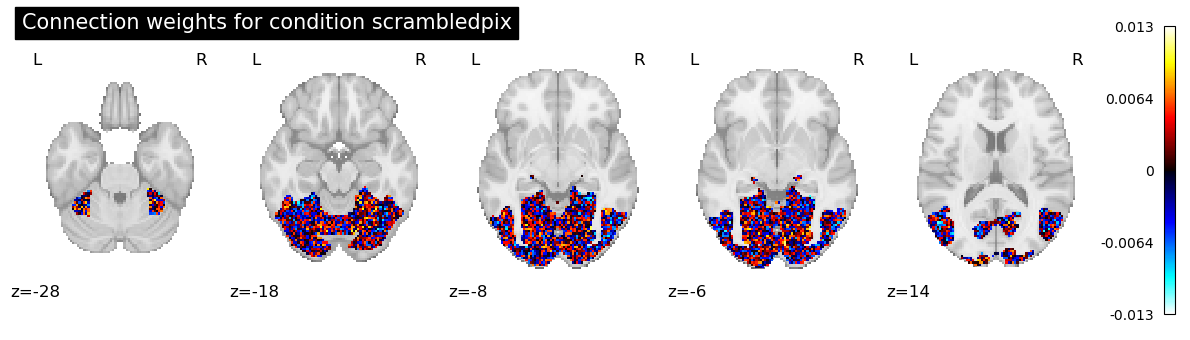

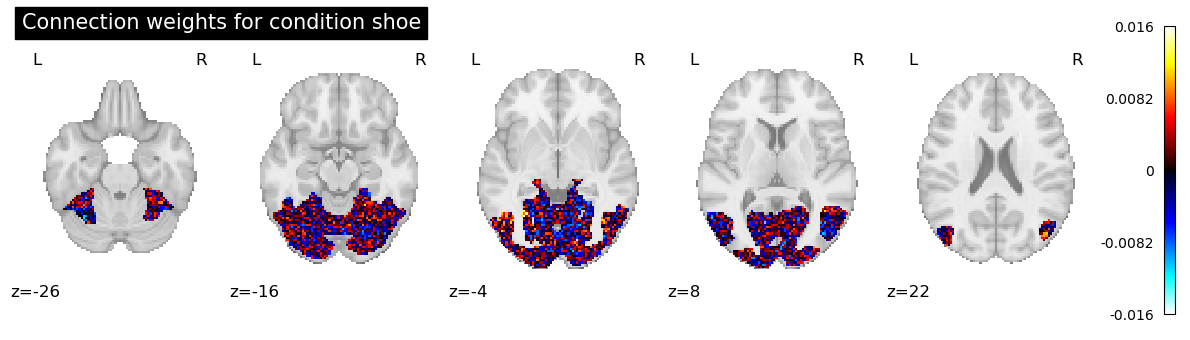

In [100]:
# render the connection weights onto the brain
from nilearn.maskers import NiftiMasker
from nilearn import plotting

fmridata_tensor, output_tensor, metadata_df = get_tensor_data(1, glm_dir)
conditions = metadata_df.conditions.unique()
conditions.sort()

voxel_weights = models[1].linear_relu_stack[0].weight.cpu().detach().numpy()
voxel_weights.shape

difumo_mask = get_difumo_mask()
masker = NiftiMasker(mask_img=difumo_mask)
masker.fit()

for condition in range(voxel_weights.shape[0]):
    weight_map = masker.inverse_transform(voxel_weights[condition])
    plotting.plot_stat_map(weight_map, title=f'Connection weights for condition {conditions[condition]}', display_mode='z', cut_coords=5, colorbar=True)
